# Exploratory Data Analysis, Feature Extraction, and Feature Selection

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif

from preprocess import Preprocessor
from dataset import DatasetLoader, FakeOrRealLabel
from eda import *

## Load dataset and Extract Features

In [2]:
# Load dataset and extract features
ds = DatasetLoader()
df = ds.load_horne2017_fakenewsdata(drop_if_less_than_num_contexts=1).as_pandas()
df = df[['id', 'label', 'title', 'content', 'ctx1_title', 'ctx1_content', 'ctx2_title', 'ctx2_content', 'ctx3_title', 'ctx3_content']]
df['label'] = df['label'].apply(int)

pp = Preprocessor(lowercase=False,remove_non_ascii=True, remove_punctuation=False, lemmatization=False, remove_stopwords=False)
for col in ["content", "ctx1_content", "ctx2_content", "ctx3_content"]:
    df[col] = df[col].apply(pp.preprocess)

df = pd.concat([df, df.apply(extract_non_latent, axis=1)], axis=1)
df = apply_textual_relevance(df)
df.to_csv('fakeNewsDataset.csv')

In [3]:
df = pd.read_csv('fakeNewsDataset.csv', index_col=0)

## Exploratory Data Analysis

In [4]:
df.head()

,id,label,title,content,ctx1_title,ctx1_content,ctx2_title,ctx2_content,ctx3_title,ctx3_content,...,ctx3_content_token,tf_idf_1_1_cosine_dist,tf_idf_1_1_word_app,tf_idf_1_1_matching,tf_idf_1_2_cosine_dist,tf_idf_1_2_word_app,tf_idf_1_2_matching,word2vec_cosine_dist,tf_idf_1_1_harmonic_mean,tf_idf_1_2_harmonic_mean
0,105_Real,1,Aziz Ansari Why Trump Makes Me Scared for My F...,"DONT go anywhere near a mosque, I told my moth...","Orlando shooting: 49 killed, shooter pledged I...","Orlando, Florida CNN \n\nAn American-born man ...",Donald Trump Seizes on Orlando Shooting and Re...,Mrs. Clinton did not use that phrase or respon...,Trump revives talk of banning Muslims after Or...,"MANCHESTER, N.H. In his first formal remarks ...",...,"['MANCHESTER', ',', 'N', '.', 'H', '.', 'In', ...",0.919901,0.309197,0.272767,0.820441,0.309197,0.264400,0.905150,0.375592,0.364291
1,124_Real,1,I Ran the C.I.A. Now I'm Endorsing Hillary Cli...,During a 33-year career at the Central Intelli...,Trump backs Putin on election meddling at summ...,HELSINKI (Reuters) - Standing side by side wit...,"Trump Discussed Pulling U.S. From NATO, Aides ...",WASHINGTON There are few things that Presiden...,Helsinki summit: Trump sides with Putin over U...,"Helsinki, Finland CNN \n\nUS President Donald ...",...,"['Helsinki', ',', 'Finland', 'CNN', 'US', 'Pre...",0.935995,0.282548,0.253652,0.835793,0.282548,0.247373,0.939637,0.350877,0.341757
2,151_Real,1,Why Donald Trump Should Not Be President\n,When Donald Trump began his improbable run for...,Donald Trump Is Elected President in Stunning ...,"That, he added, is so important to me.\n\nHe o...",How Russia Helped Swing the Election for Trump,If the WikiLeaks release was a Russian-backed ...,US election 2016: What really happened with th...,"""Since 2010, the Foundation has worked on the ...",...,"['""', 'Since', '2010', ',', 'the', 'Foundation...",0.758557,0.257991,0.220555,0.735238,0.257991,0.211052,0.867410,0.308375,0.300771
3,140_Real,1,The rise of Donald Trump is a terrifying momen...,"On Monday, Donald Trump held a rally in Manche...",The rise of Donald Trump is a terrifying momen...,"On Monday, Donald Trump held a rally in Manche...",It's a shame to lose friends over politics,Alicia Preston\n\nIt's almost over! The negati...,"Donald Trump bullied a man as overweight, then...",CNN \n\nAt a 2020 campaign rally in New Hampsh...,...,"['CNN', 'At', 'a', '2020', 'campaign', 'rally'...",0.822736,0.546355,0.524374,0.792871,0.546355,0.519702,0.977442,0.605718,0.598119
4,138_Real,1,The real Clinton email scandal is that a bulls...,"Some time ago, Hillary Clinton and her adviser...",Hillary Clinton Used Personal Email Account at...,WASHINGTON Hillary Rodham Clinton exclusively...,What the FBI Files Reveal About Hillary Clinto...,The scandal of Hillary Clintons home brew emai...,Hillary Clinton emails - what's it all about?,Hillary Clinton emails - what's it all about? ...,...,"['Hillary', 'Clinton', 'emails', '-', 'what', ...",0.897569,0.479580,0.452023,0.888399,0.479580,0.447765,0.943735,0.554370,0.551056


In [5]:
print('Example:\n')
print('Title: ', df.iloc[0]['title'])
print('Content: ', df.iloc[0]['content'][:500].replace('\n', ' '), '\n')
print('Label: ', df.iloc[0]['label'])

Example:

Title:  Aziz Ansari Why Trump Makes Me Scared for My Family

Content:  DONT go anywhere near a mosque, I told my mother. Do all your prayer at home. O.K.?  Were not going, she replied.  I am the son of Muslim immigrants. As I sent that text, in the aftermath of the horrible attack in Orlando, Fla., I realized how awful it was to tell an American citizen to be careful about how she worshiped.  Being Muslim American already carries a decent amount of baggage. In our culture, when people think Muslim, the picture in their heads is not usually of the Nobel Peace Prize  

Label:  1


Word Cloud

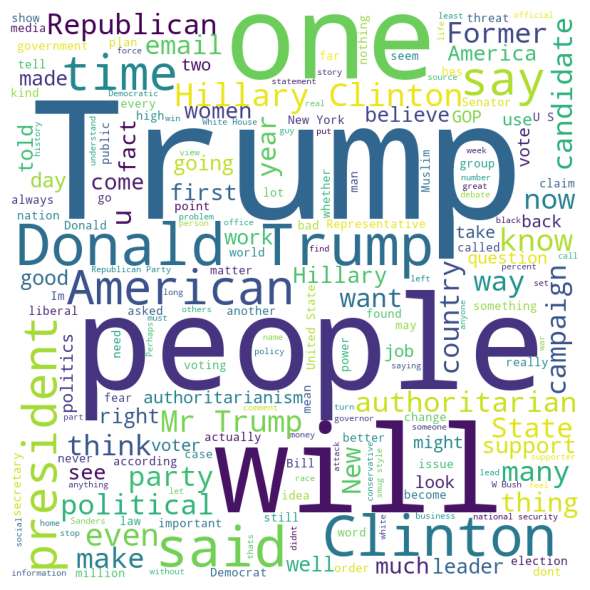

In [6]:
plot_word_cloud(df)

In [7]:
df.describe()

,label,content_div_NOUN_sum,ctx1_content_div_NOUN_sum,ctx2_content_div_NOUN_sum,ctx3_content_div_NOUN_sum,content_div_NOUN_percent,ctx1_content_div_NOUN_percent,ctx2_content_div_NOUN_percent,ctx3_content_div_NOUN_percent,content_div_VERB_sum,...,ctx3_content_read_flesch_sum,tf_idf_1_1_cosine_dist,tf_idf_1_1_word_app,tf_idf_1_1_matching,tf_idf_1_2_cosine_dist,tf_idf_1_2_word_app,tf_idf_1_2_matching,word2vec_cosine_dist,tf_idf_1_1_harmonic_mean,tf_idf_1_2_harmonic_mean
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,...,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,0.536082,105.113402,136.824742,166.061856,170.051546,0.704134,0.662912,0.649268,0.620754,70.360825,...,45.532745,0.807114,0.302662,0.278956,0.757826,0.302662,0.273422,0.917688,0.356272,0.349018
std,0.501287,107.386653,171.479531,183.648147,193.912103,0.138742,0.153762,0.175056,0.185235,62.667141,...,17.819522,0.119490,0.156439,0.155734,0.129992,0.156439,0.155961,0.047397,0.163859,0.162321
min,0.000000,12.000000,4.000000,0.000000,0.000000,0.282429,0.281682,0.000000,0.000000,7.000000,...,0.000000,0.412817,0.067323,0.055831,0.345440,0.067323,0.052899,0.634906,0.087797,0.085096
25%,0.000000,38.000000,41.000000,52.000000,56.000000,0.614213,0.545455,0.542435,0.517857,29.000000,...,38.948345,0.745778,0.175192,0.157561,0.691082,0.175192,0.152567,0.896212,0.223618,0.219172
50%,1.000000,64.000000,90.000000,120.000000,113.000000,0.719101,0.679739,0.657658,0.614555,48.000000,...,46.327336,0.822736,0.274553,0.249643,0.776036,0.274553,0.242620,0.927174,0.342369,0.329829
75%,1.000000,146.000000,165.000000,197.000000,196.000000,0.810811,0.749004,0.769841,0.733871,96.000000,...,55.848550,0.906913,0.392178,0.358563,0.856894,0.392178,0.354325,0.947692,0.454077,0.449049
max,1.000000,677.000000,1111.000000,861.000000,1026.000000,1.000000,1.000000,1.000000,1.000000,372.000000,...,82.810555,0.969999,0.845528,0.844462,0.958054,0.845528,0.848201,0.986611,0.867379,0.863604


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


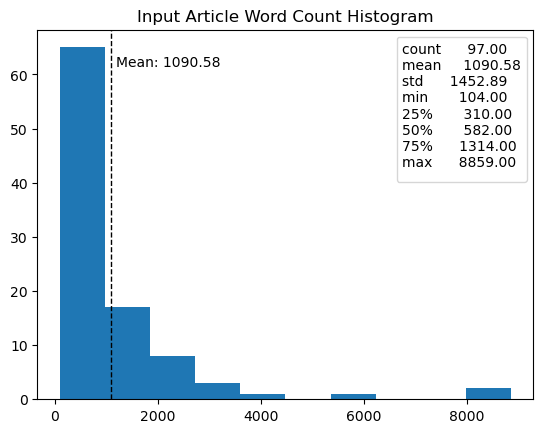

In [8]:
plot_word_count(df['content_quant_WORD_sum'], 'Input Article')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


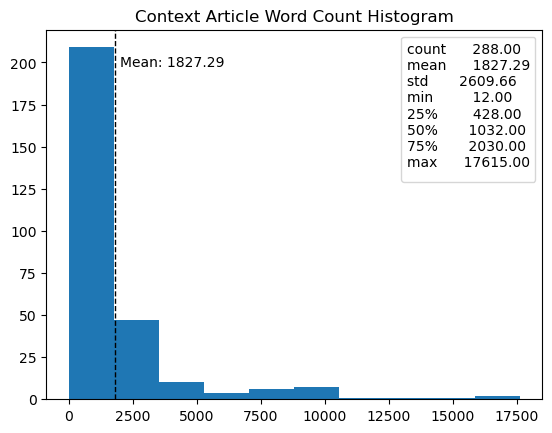

In [9]:
plot_word_count(pd.concat([
    df[df['ctx1_content_quant_WORD_sum'] > 0]['ctx1_content_quant_WORD_sum'],
    df[df['ctx2_content_quant_WORD_sum'] > 0]['ctx2_content_quant_WORD_sum'],
    df[df['ctx3_content_quant_WORD_sum'] > 0]['ctx3_content_quant_WORD_sum']   
]), 'Context Article')

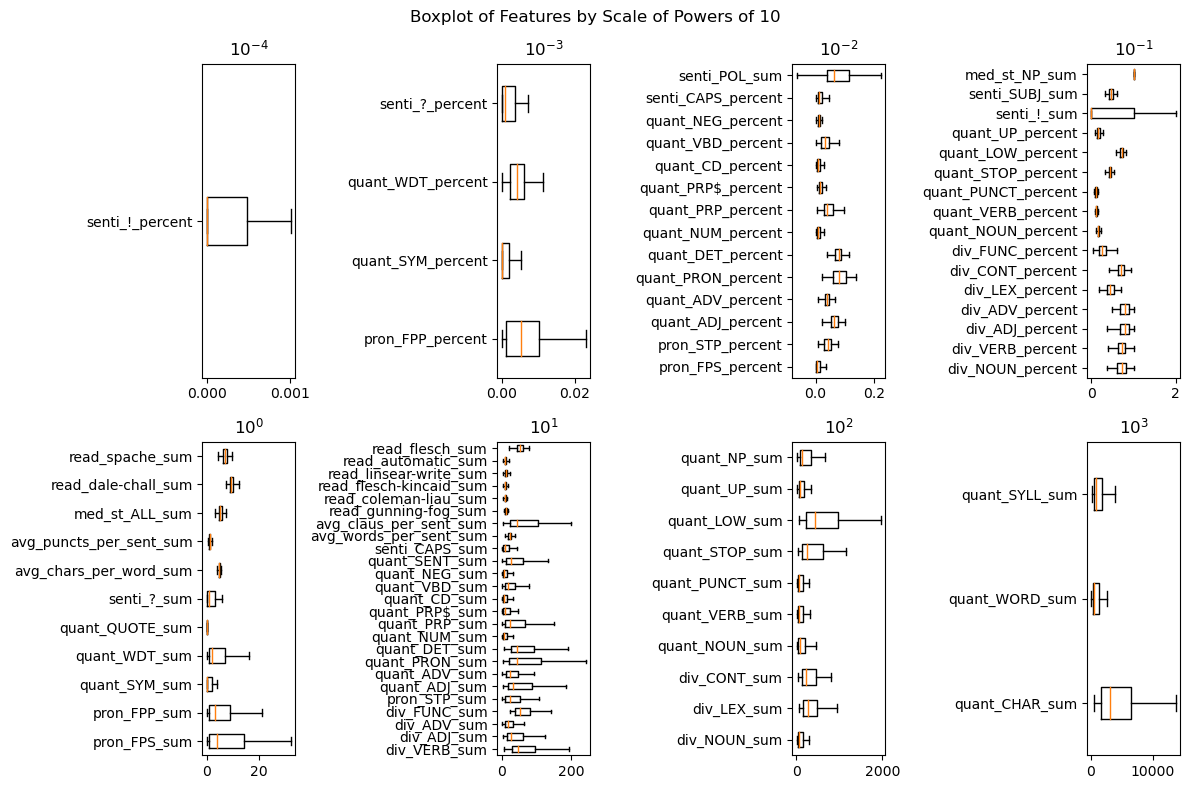

In [10]:
boxplot_feats(df)

## Feature Selection

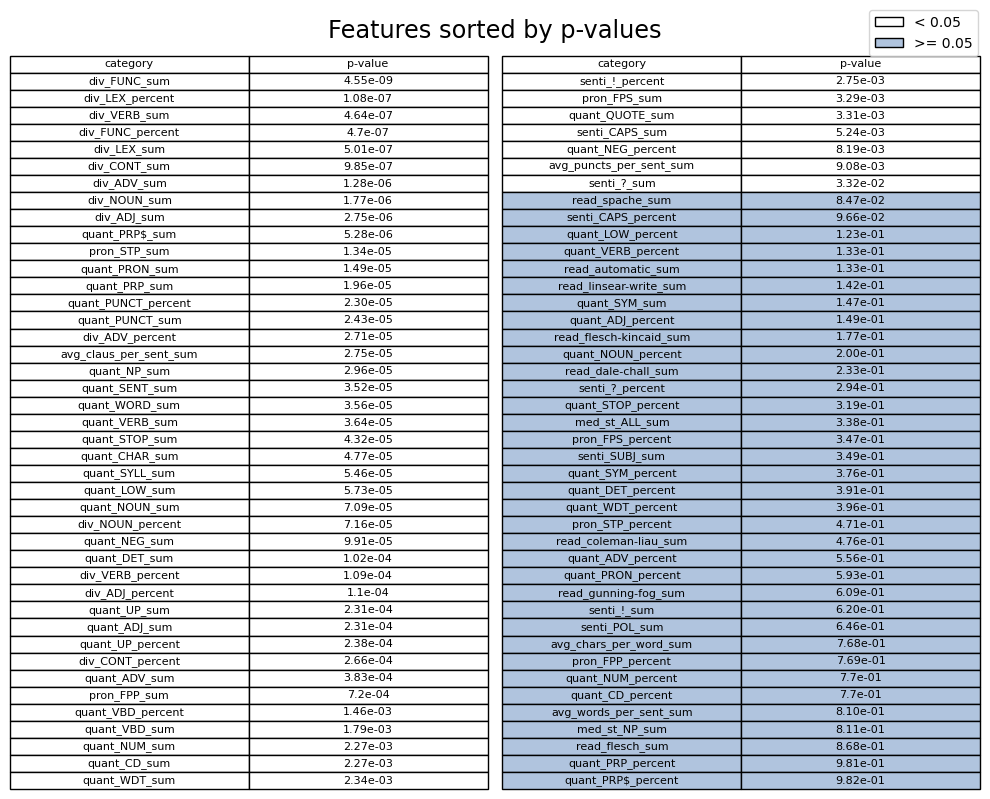

In [11]:
# Get all the features to feed into the two models
sorted_p = plot_p_values(df)

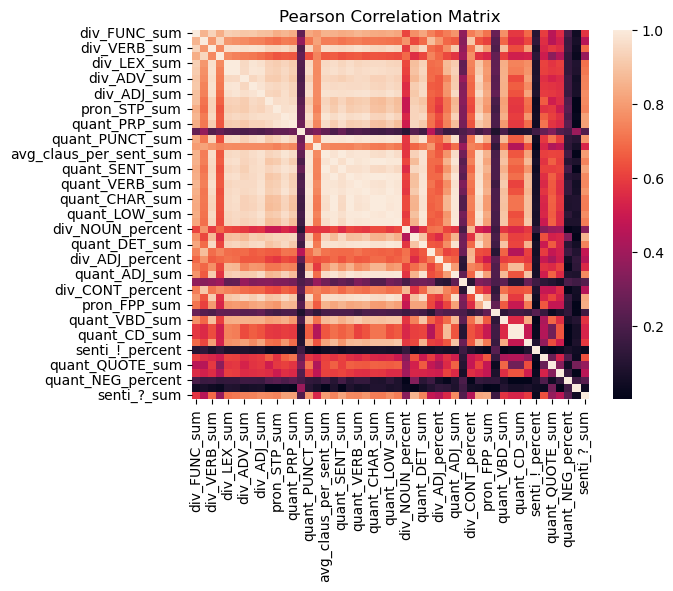

In [12]:
corr_matrx = plot_corr_heat_map(df, sorted_p)

The selected features by group are

In [13]:
selected_feats = remove_correlated_feats(corr_matrx, sorted_p)
grouped_feats = group_by_key(selected_feats)
for k, v in grouped_feats.items():
    print(f'{k}:', ' '.join([i[8:] for i in v]), '\n')

div: div_FUNC_sum div_LEX_percent div_VERB_sum div_FUNC_percent div_ADV_percent div_NOUN_percent div_VERB_percent div_ADJ_percent div_CONT_percent 

quant: quant_PRP$_sum quant_PUNCT_percent quant_PUNCT_sum quant_NEG_sum quant_UP_sum quant_UP_percent quant_VBD_percent quant_VBD_sum quant_NUM_sum quant_WDT_sum quant_QUOTE_sum quant_NEG_percent 

pron: pron_FPP_sum pron_FPS_sum 

senti: senti_!_percent senti_CAPS_sum senti_?_sum 

avg: avg_puncts_per_sent_sum 



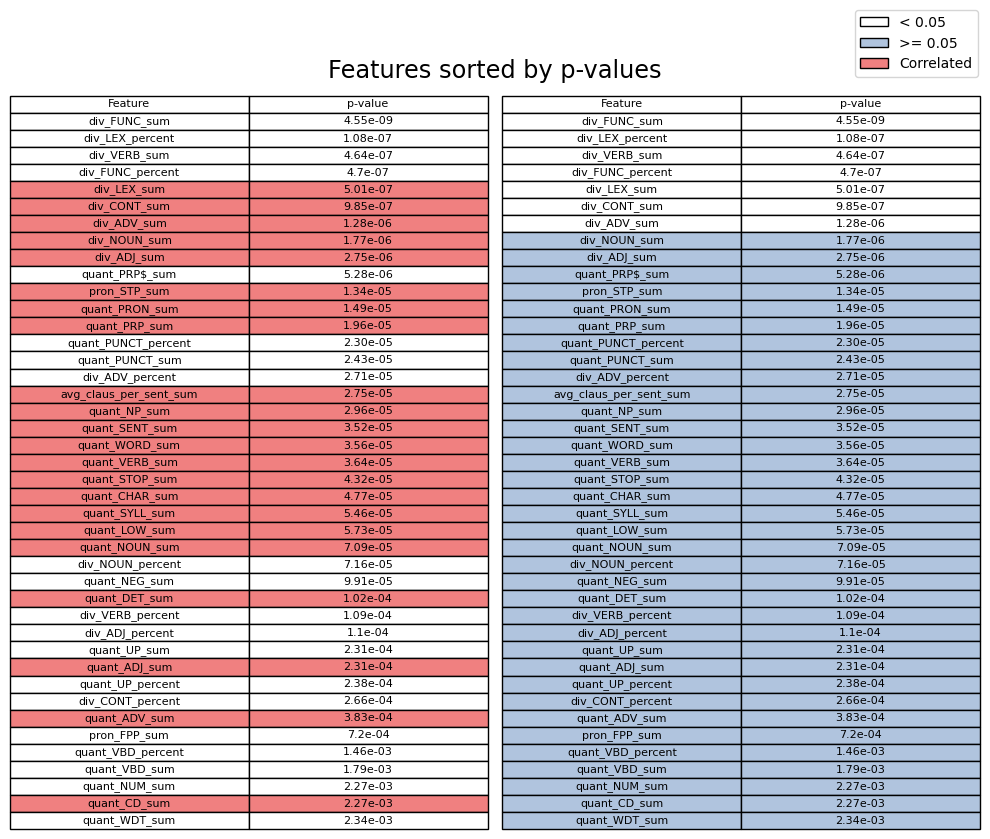

In [14]:
plot_p_values_with_correlation(sorted_p, selected_feats)

## Textual Relevance

We also add the cosine distance of vectorized prediction article against average vectorized context articles using the selected features.

Comparison between
- Cosine Distance: Selected Non Latent Feat, Word2Vec, TF-IDF(1-1), TF-IDF(1-2)
- Word App: TF-IDF(1-1), TF-IDF(1-2)
- Matching Score: TF-IDF(1-1), TF-IDF(1-2)
- Harmonic Mean of Three Metrics: TF-IDF(1-1), TF-IDF(1-2)

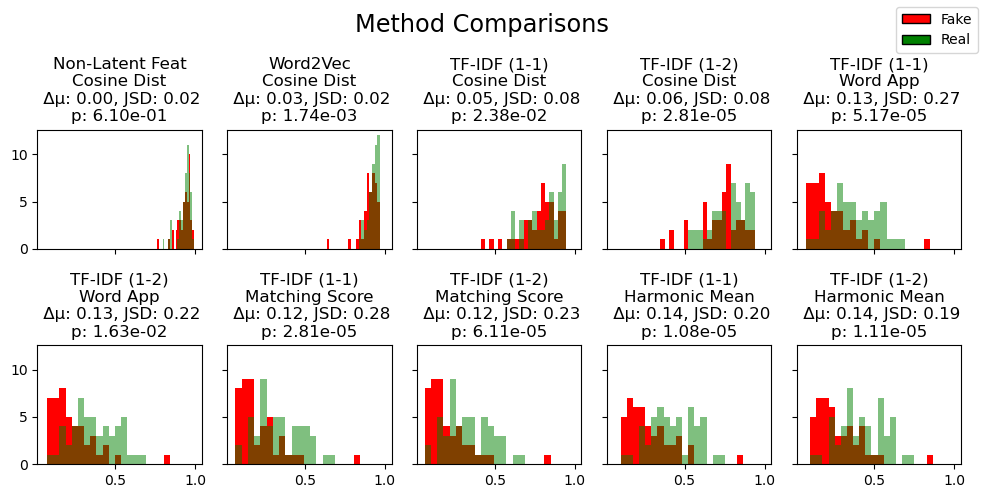

In [15]:
plot_method_comparison(df, selected_feats)

## Future work

- Apply non latent feature extraction and selection on titles, and calculate ANOVA against labels, then use selected feats as additional feats to model

- Vectorize title and body and calculate the cosine similarity between title and body, and calculate ANOVA against labels. We suspect that title and body vector of real articles have higher similarity than those of fake art